In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

In [2]:
# functions

def get_grid_corners(image) -> np.ndarray | None:
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_gray_blur = cv.GaussianBlur(image_gray, (5, 5), 0)
    image_thresh_inverted = cv.adaptiveThreshold(image_gray_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv.findContours(image_thresh_inverted, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)

    grid_contour = None
    for c in contours:
        peri = cv.arcLength(c, True)
        poly = cv.approxPolyDP(c, 0.02 * peri, True)
        if len(poly) == 4:
            grid_contour = poly
            break

    if grid_contour is not None:
        # Reshape to a simple list of 4 (x, y) coordinates
        points = grid_contour.reshape(4, 2)

        # Sort: Top-Left, Top-Right, Bottom-Right, Bottom-Left
        s = points.sum(axis=1)      # x + y
        diff = np.diff(points, axis=1) # y - x (Note: np.diff is [y-x])

        sorted_points = np.zeros((4, 2), dtype="float32")

        sorted_points[0] = points[np.argmin(s)]    # Top-left (min sum)
        sorted_points[2] = points[np.argmax(s)]    # Bottom-right (max sum)
        sorted_points[1] = points[np.argmin(diff)] # Top-right (min diff: x-y is max)
        sorted_points[3] = points[np.argmax(diff)] # Bottom-left (max diff: x-y is min)

        return sorted_points

    return None

def perspective_warp(img, points):
    side = 450

    dest_points = np.array([
        [0, 0],
        [side - 1, 0],
        [side - 1, side - 1],
        [0, side - 1]
    ], dtype="float32")

    matrix = cv.getPerspectiveTransform(points.astype("float32"), dest_points)
    warped_img = cv.warpPerspective(img, matrix, (side, side))
    return warped_img, matrix

def split_into_cells(img):
    cells = []
    cell_size = img.shape[0] // 9
    margin = cell_size // 10

    for i in range(9):
        for j in range(9):
            x1, y1 = cell_size * j + margin, cell_size * i + margin
            x2, y2 = cell_size * (j + 1) - margin, cell_size * (i + 1) - margin
            cells.append(img[y1:y2, x1:x2])
    return cells

def process_cell(cell):
    gray_cell = cv.cvtColor(cell, cv.COLOR_BGR2GRAY)
    average = np.average(gray_cell)
    _, thresholded_cell = cv.threshold(gray_cell, average * 0.5, 255, cv.THRESH_BINARY_INV)
    thresholded_resized_cell = cv.resize(thresholded_cell, (28, 28), interpolation=cv.INTER_AREA)
    center = thresholded_resized_cell[5: 24, 5: 24]
    average_on_thresholded = np.average(center)
    diff = center.astype('float32') - average_on_thresholded

    if np.count_nonzero(diff > 100) < 10:
        return cell, False
    else:

        return thresholded_resized_cell, True

In [3]:
# get image
image_path = '../static/img/img6.jpeg'
image = cv.imread(image_path)

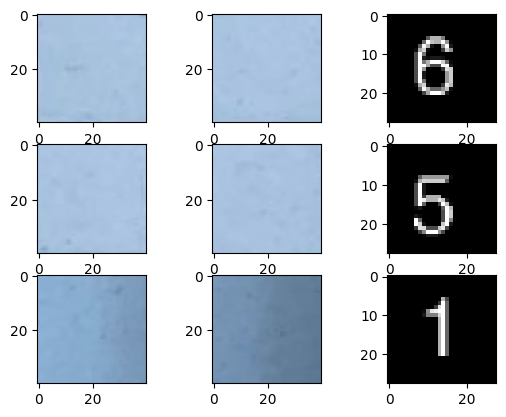

In [4]:
# process

corners = get_grid_corners(image)
grid_image, matrix = perspective_warp(image, corners)
cells = split_into_cells(grid_image)
cells_processed = [process_cell(cell) for cell in cells]

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cells_processed[i+ 9*8][0], cmap='gray')

In [5]:
# Define model
class CNN_Ultra(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Ultra, self).__init__()

        # Layer 1: Learn basic shapes (curves, lines)
        # Input: (1, 28, 28) -> Output: (32, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pool reduces to (32, 14, 14)

        # Layer 2: Learn combinations of shapes (loops, corners)
        # Input: (32, 14, 14) -> Output: (64, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Pool reduces to (64, 7, 7)

        # Fully Connected Layers
        # We flattened 64 channels * 7 * 7 pixels = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5) # Crucial to prevent overfitting on the 8 fonts
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1) # Flatten (Batch_Size, 3136)

        # Classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN_Ultra()
model.load_state_dict(torch.load('../models/CNN_Ultra.pth', map_location=torch.device('cpu')))
model.eval()

CNN_Ultra(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

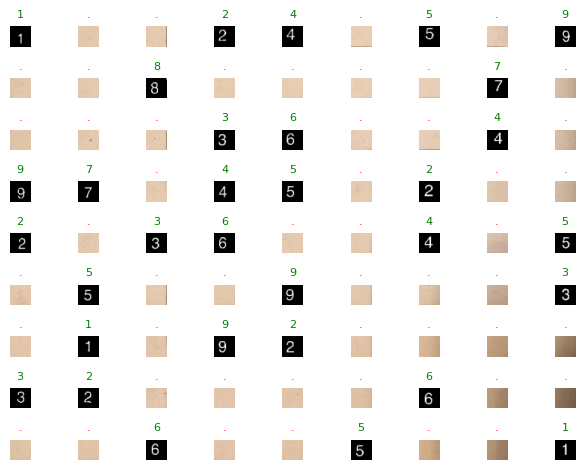

In [6]:
for i, cell in enumerate(cells_processed):
    plt.subplot(9, 9, i + 1)

    if cell[1]:
        plt.title(str(model(torch.tensor(cell[0] / 255.0, dtype=torch.float32).reshape(1, 1, 28, 28)).argmax().item()), fontsize=8, color='green')
    else:
        plt.title('.', fontsize=8, color='red')
    # Show the image
    plt.imshow(cv.cvtColor(cell[0], cv.COLOR_BGR2RGB))
    plt.axis('off')

# Adjust layout prevents titles from overlapping with the images above them
plt.tight_layout()
plt.show()

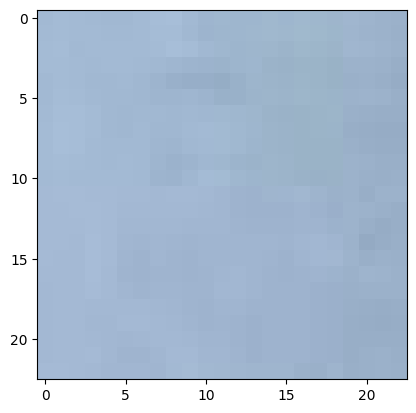

In [7]:
plt.imshow(cells_processed[35][0][3:26, 3:26], cmap='gray')

In [8]:
# solve sudoku
def isSafe(mat, row, col, num):
    # Check if num exists in the row
    for x in range(9):
        if mat[row][x] == num:
            return False

    # Check if num exists in the col
    for x in range(9):
        if mat[x][col] == num:
            return False

    # Check if num exists in the 3x3 sub-matrix
    startRow = row - (row % 3)
    startCol = col - (col % 3)

    for i in range(3):
        for j in range(3):
            if mat[i + startRow][j + startCol] == num:
                return False

    return True

# Function to solve the Sudoku problem
def solveSudokuRec(mat, row, col):
    # base case: Reached nth column of the last row
    if row == 8 and col == 9:
        return True

    # If last column of the row go to the next row
    if col == 9:
        row += 1
        col = 0

    # If cell is already occupied then move forward
    if mat[row][col] != 0:
        return solveSudokuRec(mat, row, col + 1)

    for num in range(1, 10):

        # If it is safe to place num at current position
        if isSafe(mat, row, col, num):
            mat[row][col] = num
            if solveSudokuRec(mat, row, col + 1):
                return True
            mat[row][col] = 0

    return False

def solveSudoku(mat):
    solveSudokuRec(mat, 0, 0)

sudoku_original = [[model(torch.tensor(cells_processed[j][0] / 255.0, dtype=torch.float32).reshape(1, 1, 28, 28)).argmax().item() if cells_processed[j][1] else 0 for j in range(i,i+9)] for i in range(81) if i % 9 == 0]
sudoku_solved = copy.deepcopy(sudoku_original)
solveSudoku(sudoku_solved)

def show_sudoku(sudoku):
    for line in sudoku:
        for cell in line:
            print(cell, end=' ')
        print()

show_sudoku(sudoku_original)
print('-'*30)
show_sudoku(sudoku_solved)

1 0 0 2 4 0 5 0 9 
0 0 8 0 0 0 0 7 0 
0 0 0 3 6 0 0 4 0 
9 7 0 4 5 0 2 0 0 
2 0 3 6 0 0 4 0 5 
0 5 0 0 9 0 0 0 3 
0 1 0 9 2 0 0 0 0 
3 2 0 0 0 0 6 0 0 
0 0 6 0 0 5 0 0 1 
------------------------------
1 3 7 2 4 8 5 6 9 
4 6 8 5 1 9 3 7 2 
5 9 2 3 6 7 1 4 8 
9 7 1 4 5 3 2 8 6 
2 8 3 6 7 1 4 9 5 
6 5 4 8 9 2 7 1 3 
7 1 5 9 2 6 8 3 4 
3 2 9 1 8 4 6 5 7 
8 4 6 7 3 5 9 2 1 


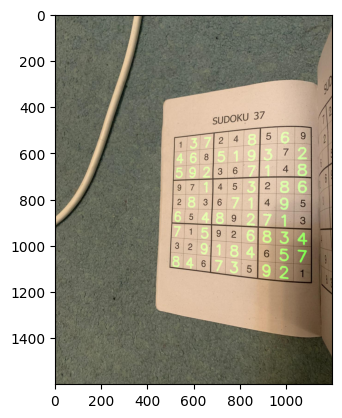

In [9]:
def draw_solution_on_original(original_image, matrix, solution_grid, original_grid):
    # 1. Create a blank image with the same size as the warped grid (450x450)
    side = 450
    flat_overlay = np.zeros((side, side, 3), dtype="uint8")
    cell_size = side // 9

    # 2. Draw the missing numbers on the flat overlay
    for i in range(9):
        for j in range(9):
            # Only draw if the cell was originally empty (0)
            if original_grid[i][j] == 0:
                text = str(solution_grid[i][j])

                # Calculate text size to center it perfectly
                font = cv.FONT_HERSHEY_SIMPLEX
                font_scale = 1.5
                thickness = 3
                (text_w, text_h), _ = cv.getTextSize(text, font, font_scale, thickness)

                # Calculate x, y to center the text in the cell
                # x = cell_left + half_cell_width - half_text_width
                x = int((j * cell_size) + (cell_size / 2) - (text_w / 2))
                y = int((i * cell_size) + (cell_size / 2) + (text_h / 2))

                # Draw the number in Green (BGR format: 0, 255, 0)
                cv.putText(flat_overlay, text, (x, y), font, font_scale, (0, 255, 0), thickness)

    # 3. Calculate the Inverse Matrix
    # We want to go from Warped -> Original, so we invert the matrix
    inv_matrix = np.linalg.inv(matrix)

    # 4. Warp the overlay back to the original image shape
    h, w, _ = original_image.shape
    warped_overlay = cv.warpPerspective(flat_overlay, inv_matrix, (w, h))

    # 5. Combine the images
    # Since the background of warped_overlay is black (0,0,0),
    # adding it to the original will just overlay the green pixels.
    result = cv.addWeighted(original_image, 1, warped_overlay, 1, 0)

    return result

final_image = draw_solution_on_original(cv.cvtColor(image, cv.COLOR_BGR2RGB), matrix, sudoku_solved, sudoku_original)
plt.imshow(final_image)